# Credit Risk Analysis

#### จัดทำโดย นายภูมิธีรภัทร พลพุทธา

#### โปรเจกต์นี้เป็น workshop การวิเคราะห์ความเสี่ยงด้านสินเชื่อ (Credit Risk Analysis) และการพัฒนาแบบจำลองคะแนนเครดิต (Credit Scoring / Scorecard Model) โดยใช้ข้อมูลลูกค้าและเทคนิคทางสถิติเพื่อศึกษาวิเคราะห์ถึงปัจจัยต่อการผิดนัดชำระหนี้ จากตัวแปร Demographic Data ในด้านต่างๆ อาทิเช่น อายุ, รายได้, การถือครองที่อยู่อาศัย, อายุงาน, ดอกเบี้ย, ยิดสินเชื่อ, และอื่นๆ ผ่านเครื่องมือ python JupyterLab ในการวิเคราะห์

#### โดยใช้ข้อมูลจาก simulating credit bureau data

#### ที่มาของข้อมูล https://www.kaggle.com/datasets/laotse/credit-risk-dataset

| Feature Name                 | Description                               |
|------------------------------|-------------------------------------------|
| person_age                   | Age                                       |
| person_income                | Annual Income                             |
| person_home_ownership        | Home ownership                            |
| person_emp_length            | Employment length (in years)              |
| loan_intent                  | Loan intent                               |
| loan_grade                   | Loan grade                                |
| loan_amnt                    | Loan amount                               |
| loan_int_rate                | Interest rate                             |
| loan_status                  | Loan status (0 is non default, 1 is default) |
| loan_percent_income          | Percent income                            |
| cb_person_default_on_file    | Historical default                        |
| cb_preson_cred_hist_length   | Credit history length                     |

In [1]:
# Install library
#!pip install kagglehub
#!pip install statsmodels
#!pip install pipreqs

## Import Library and Setting

In [96]:
# Import Library
import pandas as pd
import numpy as np
import seaborn as sns
import kagglehub
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
import os
import pickle

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression


# Checking library version
print("---Library version---", end = '\n')
print('pandas version: ', pd.__version__)
print('numpy version: ', np.__version__)
print('seaborn version: ', sns.__version__)
print('matplotlib version: ', mpl.__version__, end = '\n\n')

---Library version---
pandas version:  2.2.2
numpy version:  1.26.3
seaborn version:  0.13.2
matplotlib version:  3.9.2



In [3]:
# Setting library
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:,.0f}'.format

mpl.font_manager.fontManager.addfont("asset\\fonts\\Sarabun-Regular.ttf")
mpl.rc('font', family='Sarabun')
plt.rcParams ['font.family'] = ('Sarabun')

# ignore warnings
warnings.filterwarnings('ignore')

In [4]:
# Print current working directory
print("---Working Directory---", end = '\n')
print('List of Directory:', os.listdir(os.getcwd()))
print('List of Directory (Data):', os.listdir(os.getcwd() + '\\data'))

---Working Directory---
List of Directory: ['.git', '.ipynb_checkpoints', 'asset', 'data', 'notebooks', 'readme.md', 'requirements.txt', 'Risk-Creidit-Analysis_notebook.ipynb', 'Risk-Creidit-Analysis_notebook.pdf', 'รายงานการวิเคราะห์ความเสี่ยงสินเชื่อ.pdf']
List of Directory (Data): ['.ipynb_checkpoints', 'processed', 'raw']


## Import Data

In [5]:
raw_data = "credit_risk_dataset.csv"

data = pd.read_csv(filepath_or_buffer=f'data/raw/{raw_data}')

with pd.option_context('display.max_rows', 10):
    display(data)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123,PERSONAL,D,35000,16,1,1,Y,3
1,21,9600,OWN,5,EDUCATION,B,1000,11,0,0,N,2
2,25,9600,MORTGAGE,1,MEDICAL,C,5500,13,1,1,N,3
3,23,65500,RENT,4,MEDICAL,C,35000,15,1,1,N,2
4,24,54400,RENT,8,MEDICAL,C,35000,14,1,1,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1,PERSONAL,C,5800,13,0,0,N,30
32577,54,120000,MORTGAGE,4,PERSONAL,A,17625,7,0,0,N,19
32578,65,76000,RENT,3,HOMEIMPROVEMENT,B,35000,11,1,0,N,28
32579,56,150000,MORTGAGE,5,PERSONAL,B,15000,11,0,0,N,26


In [6]:
print(f'Records: {data.shape[0]}, Variable: {data.shape[1]}')

Records: 32581, Variable: 12


## Overall of Data

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [8]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,"32,581","32,581","31,686","32,581","29,465","32,581","32,581","32,581"
mean,28,"66,075",5,"9,589",11,0,0,6
std,6,"61,983",4,"6,322",3,0,0,4
min,20,"4,000",0,500,5,0,0,2
25%,23,"38,500",2,"5,000",8,0,0,3
50%,26,"55,000",4,"8,000",11,0,0,4
75%,30,"79,200",7,"12,200",13,0,0,8
max,144,"6,000,000",123,"35,000",23,1,1,30


## Data Distribution

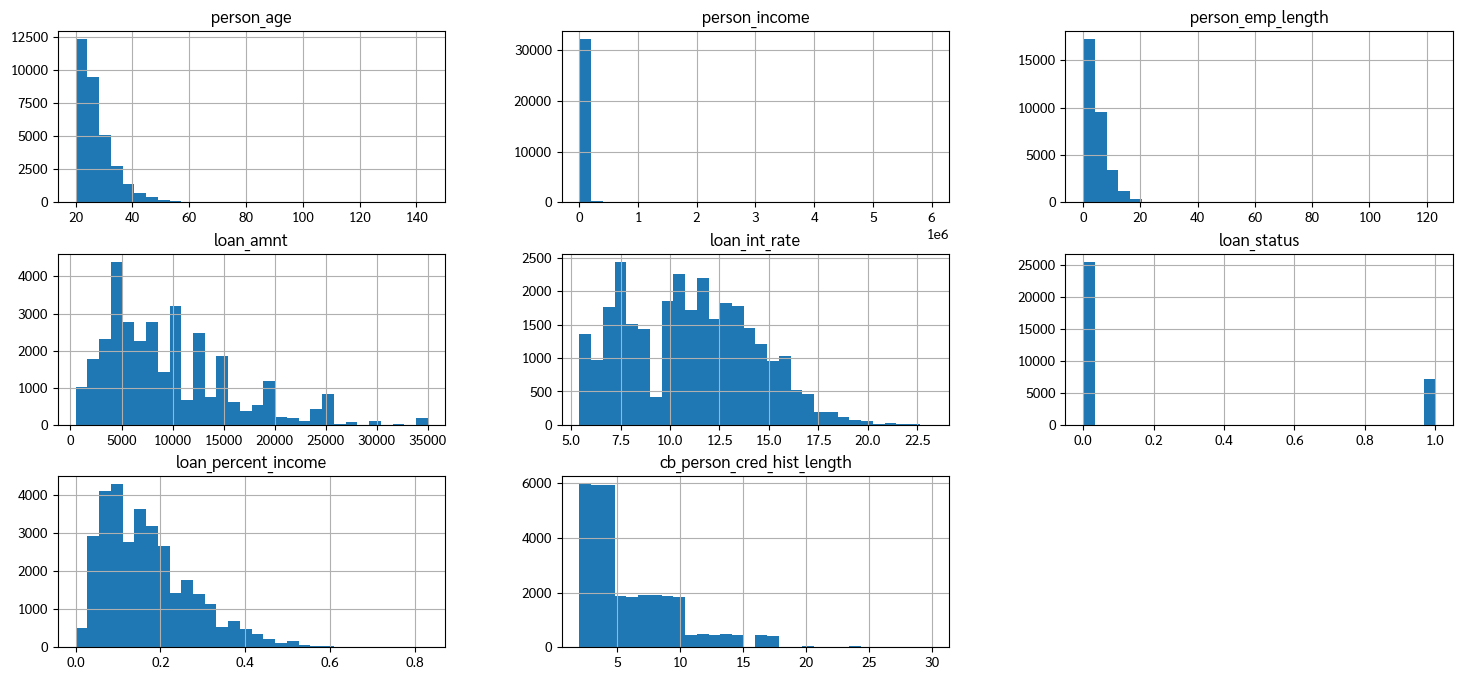

In [9]:
data.select_dtypes('number').hist(bins=30, figsize=(18,8))
plt.show()

## Data Outlier Cleaning

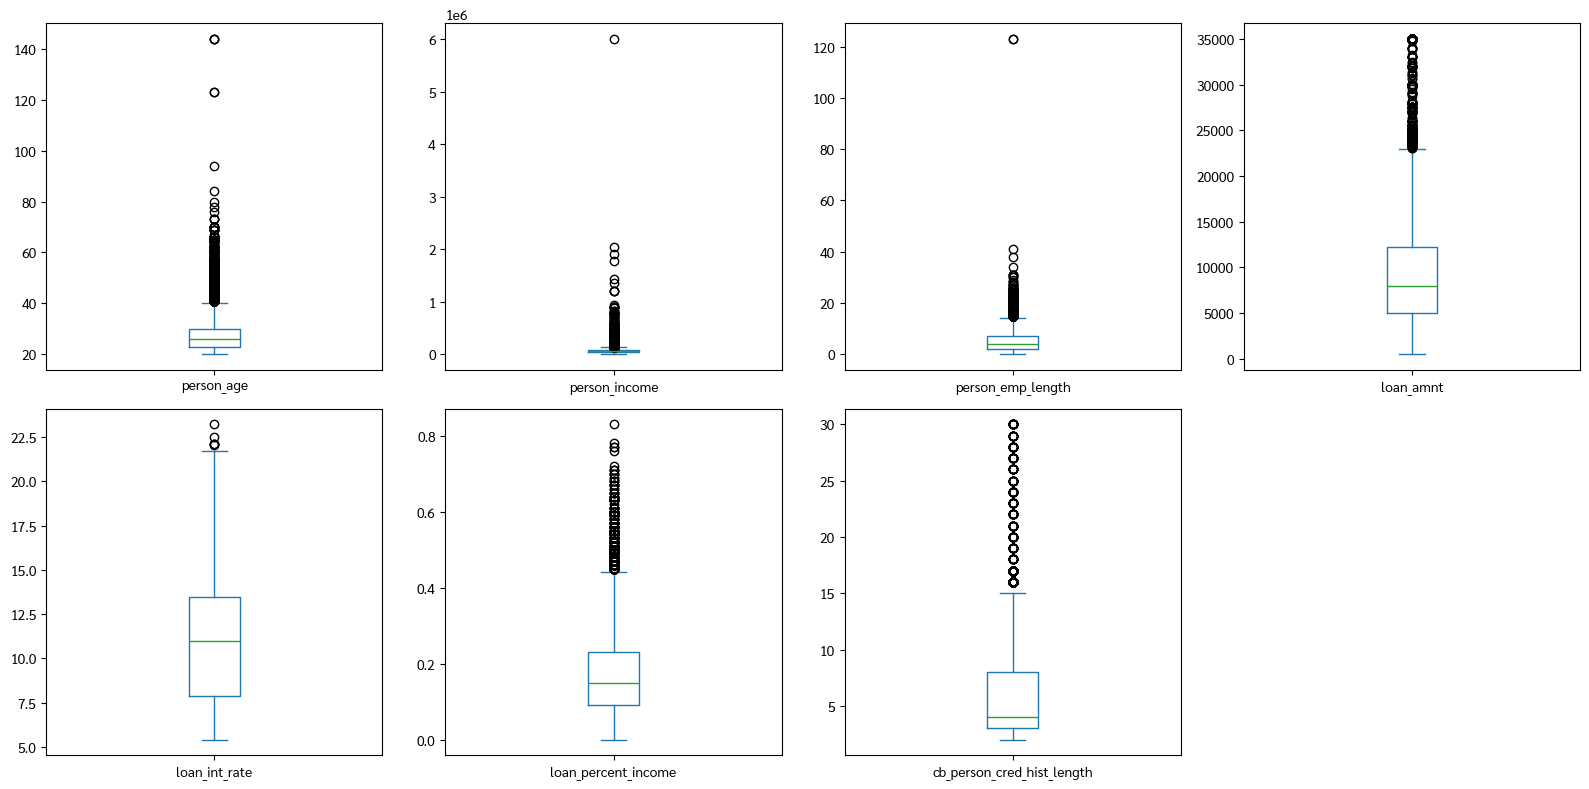

In [10]:
numeric_df_plot = data.select_dtypes(include='number').drop(columns=['loan_status'])

numeric_df_plot.plot(
    kind='box',
    subplots=True,
    layout=(2, 4),   # adjust rows/cols to match remaining variables
    figsize=(16, 8)
)

plt.tight_layout()
plt.show()


## person_age

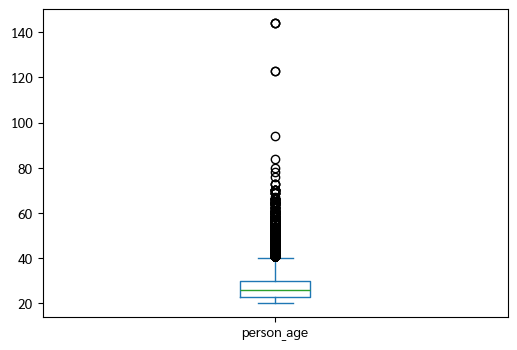

count   32,581
mean        28
std          6
min         20
25%         23
50%         26
75%         30
max        144
Name: person_age, dtype: float64


In [11]:
data['person_age'].plot(kind='box', figsize=(6,4))
plt.show()

print(data['person_age'].describe())


In [12]:
data = data[(data['person_age'] >= 20) & (data['person_age'] <= 90)]

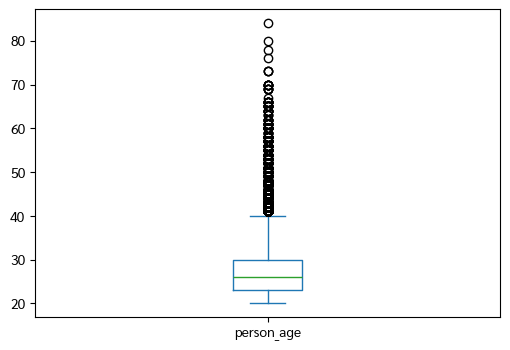

count   32,575
mean        28
std          6
min         20
25%         23
50%         26
75%         30
max         84
Name: person_age, dtype: float64


In [13]:
data['person_age'].plot(kind='box', figsize=(6,4))
plt.show()

print(data['person_age'].describe())

## person_income

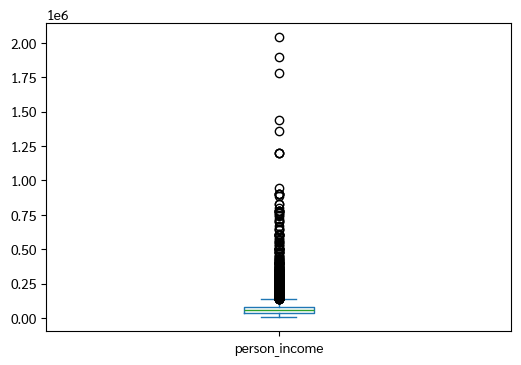

count      32,575
mean       65,883
std        52,535
min         4,000
25%        38,500
50%        55,000
75%        79,200
max     2,039,784
Name: person_income, dtype: float64


In [14]:
data['person_income'].plot(kind='box', figsize=(6,4))
plt.show()

print(data['person_income'].describe())


## person_emp_length

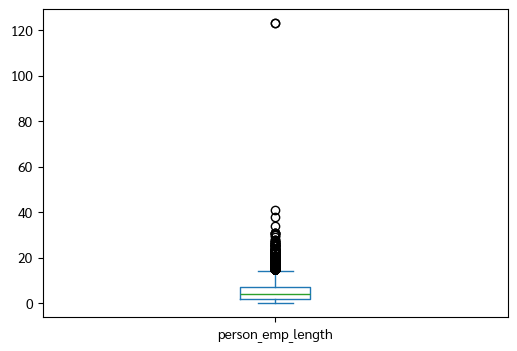

count   31,680
mean         5
std          4
min          0
25%          2
50%          4
75%          7
max        123
Name: person_emp_length, dtype: float64


In [15]:
data['person_emp_length'].plot(kind='box', figsize=(6,4))
plt.show()

print(data['person_emp_length'].describe())


In [16]:
data = data[data['person_emp_length'] != 123]

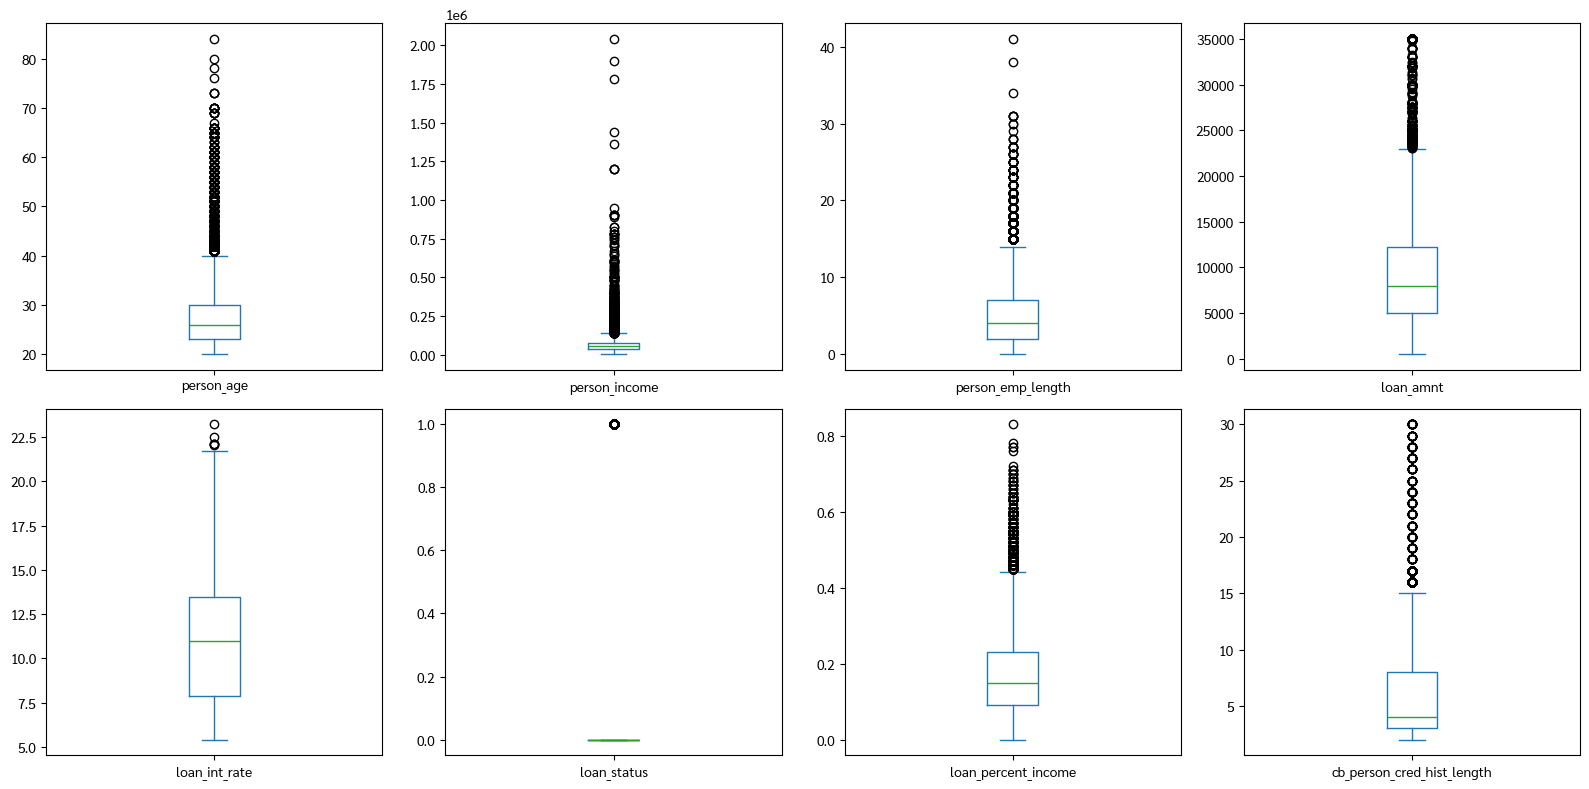

In [17]:
data.plot(
    kind='box',
    subplots=True,
    layout=(2, 4),   # adjust rows/cols to match remaining variables
    figsize=(16, 8)
)

plt.tight_layout()
plt.show()


## Category Data Exploring

In [18]:
cat_cols = data.select_dtypes(include=['object', 'category']).columns
unique_counts = data[cat_cols].nunique()

print(unique_counts)

person_home_ownership        4
loan_intent                  6
loan_grade                   7
cb_person_default_on_file    2
dtype: int64


In [19]:
for col in cat_cols:
    print(f"\nColumn: {col}")
    print(data[col].value_counts(dropna=False))


Column: person_home_ownership
person_home_ownership
RENT        16441
MORTGAGE    13441
OWN          2584
OTHER         107
Name: count, dtype: int64

Column: loan_intent
loan_intent
EDUCATION            6451
MEDICAL              6070
VENTURE              5716
PERSONAL             5519
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: count, dtype: int64

Column: loan_grade
loan_grade
A    10776
B    10448
C     6455
D     3625
E      964
F      241
G       64
Name: count, dtype: int64

Column: cb_person_default_on_file
cb_person_default_on_file
N    26829
Y     5744
Name: count, dtype: int64


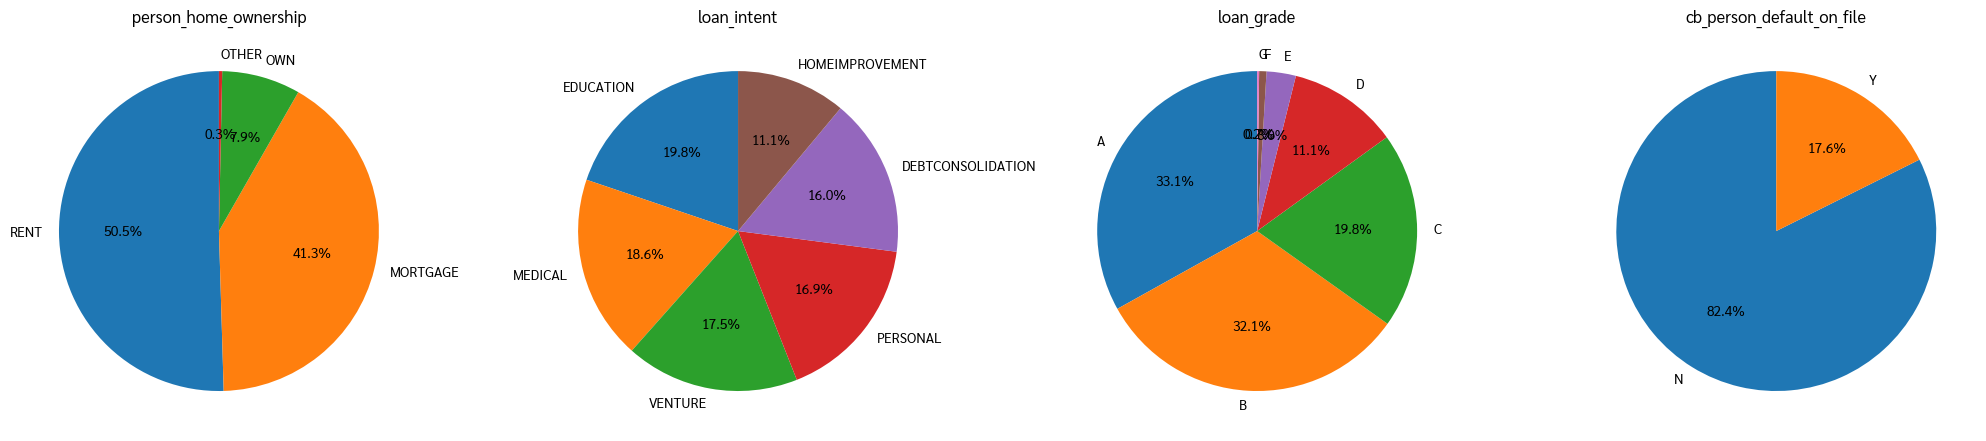

In [20]:
n = len(cat_cols)
# Create 1 row with n columns
fig, axes = plt.subplots(1, n, figsize=(5*n, 5))

for i, col in enumerate(cat_cols):
    counts = data[col].value_counts(dropna=False)
    axes[i].pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        startangle=90
    )
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

## Rename Columns

In [21]:
df = data.rename(columns=lambda x: x.replace("person_", "").title())
display(df)

,Age,Income,Home_Ownership,Emp_Length,Loan_Intent,Loan_Grade,Loan_Amnt,Loan_Int_Rate,Loan_Status,Loan_Percent_Income,Cb_Default_On_File,Cb_Cred_Hist_Length
1,21,9600,OWN,5,EDUCATION,B,1000,11,0,0,N,2
2,25,9600,MORTGAGE,1,MEDICAL,C,5500,13,1,1,N,3
3,23,65500,RENT,4,MEDICAL,C,35000,15,1,1,N,2
4,24,54400,RENT,8,MEDICAL,C,35000,14,1,1,Y,4
5,21,9900,OWN,2,VENTURE,A,2500,7,1,0,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1,PERSONAL,C,5800,13,0,0,N,30
32577,54,120000,MORTGAGE,4,PERSONAL,A,17625,7,0,0,N,19
32578,65,76000,RENT,3,HOMEIMPROVEMENT,B,35000,11,1,0,N,28
32579,56,150000,MORTGAGE,5,PERSONAL,B,15000,11,0,0,N,26


## Change Columns Type

In [22]:
df["Emp_Length"] = df["Emp_Length"].astype("Int64")
df["Loan_Int_Rate"] = df["Loan_Int_Rate"].astype("Float64")

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32573 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  32573 non-null  int64  
 1   Income               32573 non-null  int64  
 2   Home_Ownership       32573 non-null  object 
 3   Emp_Length           31678 non-null  Int64  
 4   Loan_Intent          32573 non-null  object 
 5   Loan_Grade           32573 non-null  object 
 6   Loan_Amnt            32573 non-null  int64  
 7   Loan_Int_Rate        29459 non-null  Float64
 8   Loan_Status          32573 non-null  int64  
 9   Loan_Percent_Income  32573 non-null  float64
 10  Cb_Default_On_File   32573 non-null  object 
 11  Cb_Cred_Hist_Length  32573 non-null  int64  
dtypes: Float64(1), Int64(1), float64(1), int64(5), object(4)
memory usage: 3.3+ MB


## Check Missing or NaN value

In [24]:
for i in df.columns:
    print(f'{i} : {df[i].isna().sum()}')

Age : 0
Income : 0
Home_Ownership : 0
Emp_Length : 895
Loan_Intent : 0
Loan_Grade : 0
Loan_Amnt : 0
Loan_Int_Rate : 3114
Loan_Status : 0
Loan_Percent_Income : 0
Cb_Default_On_File : 0
Cb_Cred_Hist_Length : 0


In [25]:
print('String columns with contain NaN values', end='\n\n')
for column in df.columns:
    if df[column].dtype == 'O' and df[column].isna().any():
        print(f"NaN in : '{column}'")
    else:
        print("None")

String columns with contain NaN values

None
None
None
None
None
None
None
None
None
None
None
None


## Export Processed Data

In [26]:
print("Rows before:", df.shape[0])

Rows before: 32573


In [27]:
# Drop rows with any NaN values
df_clean = df.dropna()

display(df_clean)

,Age,Income,Home_Ownership,Emp_Length,Loan_Intent,Loan_Grade,Loan_Amnt,Loan_Int_Rate,Loan_Status,Loan_Percent_Income,Cb_Default_On_File,Cb_Cred_Hist_Length
1,21,9600,OWN,5,EDUCATION,B,1000,11,0,0,N,2
2,25,9600,MORTGAGE,1,MEDICAL,C,5500,13,1,1,N,3
3,23,65500,RENT,4,MEDICAL,C,35000,15,1,1,N,2
4,24,54400,RENT,8,MEDICAL,C,35000,14,1,1,Y,4
5,21,9900,OWN,2,VENTURE,A,2500,7,1,0,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1,PERSONAL,C,5800,13,0,0,N,30
32577,54,120000,MORTGAGE,4,PERSONAL,A,17625,7,0,0,N,19
32578,65,76000,RENT,3,HOMEIMPROVEMENT,B,35000,11,1,0,N,28
32579,56,150000,MORTGAGE,5,PERSONAL,B,15000,11,0,0,N,26


In [28]:
print("Rows after:", df_clean.shape[0])

Rows after: 28632


In [29]:
df.shape[0] - df_clean.shape[0]

3941

In [30]:
df_clean.isna().sum()

Age                    0
Income                 0
Home_Ownership         0
Emp_Length             0
Loan_Intent            0
Loan_Grade             0
Loan_Amnt              0
Loan_Int_Rate          0
Loan_Status            0
Loan_Percent_Income    0
Cb_Default_On_File     0
Cb_Cred_Hist_Length    0
dtype: int64

In [31]:
file_name = "credit_risk_dataset"
flag = "cleaned"

df_clean.to_csv(f'data/processed/' + file_name + '_' + flag + '.csv', index=False)

## Analysis and Understand insight of the Data

In [32]:
pd.reset_option('display.float_format')
display(df.corr(numeric_only=True))
pd.options.display.float_format = '{:,.0f}'.format

,Age,Income,Emp_Length,Loan_Amnt,Loan_Int_Rate,Loan_Status,Loan_Percent_Income,Cb_Cred_Hist_Length
Age,1.000000,0.141007,0.173183,0.052002,0.011966,-0.020549,-0.041968,0.878287
Income,0.141007,1.000000,0.154726,0.317489,-0.001121,-0.168500,-0.294542,0.123230
Emp_Length,0.173183,0.154726,1.000000,0.110980,-0.058263,-0.085983,-0.058533,0.149625
Loan_Amnt,0.052002,0.317489,0.110980,1.000000,0.146803,0.105233,0.572444,0.042336
Loan_Int_Rate,0.011966,-0.001121,-0.058263,0.146803,1.000000,0.335092,0.120218,0.016656
Loan_Status,-0.020549,-0.168500,-0.085983,0.105233,0.335092,1.000000,0.379272,-0.015394
Loan_Percent_Income,-0.041968,-0.294542,-0.058533,0.572444,0.120218,0.379272,1.000000,-0.031611
Cb_Cred_Hist_Length,0.878287,0.123230,0.149625,0.042336,0.016656,-0.015394,-0.031611,1.000000


## Correlation of Variable

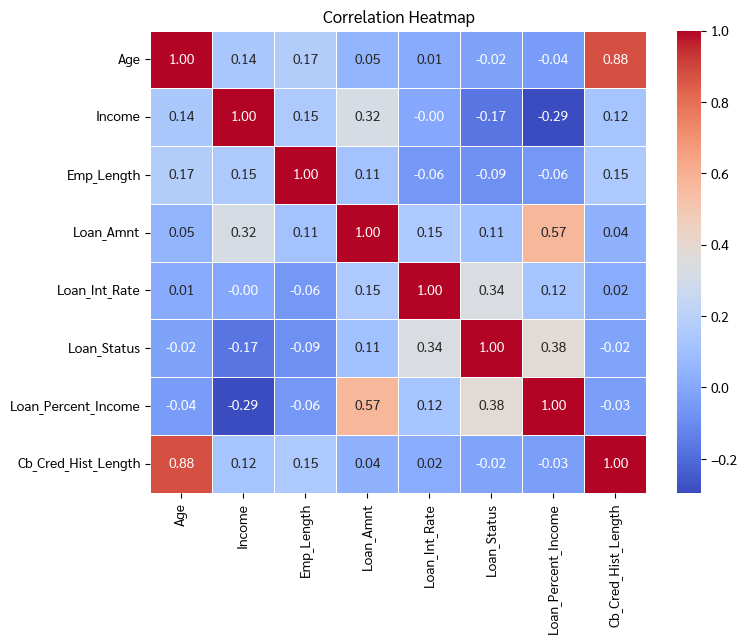

In [33]:
# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

## Variance Inflation Factor (VIF)

In [34]:
numeric_df = pd.DataFrame(df.select_dtypes(include=["number"]))
numeric_df

,Age,Income,Emp_Length,Loan_Amnt,Loan_Int_Rate,Loan_Status,Loan_Percent_Income,Cb_Cred_Hist_Length
1,21,9600,5,1000,11,0,0,2
2,25,9600,1,5500,13,1,1,3
3,23,65500,4,35000,15,1,1,2
4,24,54400,8,35000,14,1,1,4
5,21,9900,2,2500,7,1,0,2
...,...,...,...,...,...,...,...,...
32576,57,53000,1,5800,13,0,0,30
32577,54,120000,4,17625,7,0,0,19
32578,65,76000,3,35000,11,1,0,28
32579,56,150000,5,15000,11,0,0,26


In [35]:
# Add constant for intercept
X = add_constant(df.select_dtypes(include="number").dropna())

In [36]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28632 entries, 1 to 32580
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   const                28632 non-null  float64
 1   Age                  28632 non-null  int64  
 2   Income               28632 non-null  int64  
 3   Emp_Length           28632 non-null  Int64  
 4   Loan_Amnt            28632 non-null  int64  
 5   Loan_Int_Rate        28632 non-null  Float64
 6   Loan_Status          28632 non-null  int64  
 7   Loan_Percent_Income  28632 non-null  float64
 8   Cb_Cred_Hist_Length  28632 non-null  int64  
dtypes: Float64(1), Int64(1), float64(2), int64(5)
memory usage: 2.2 MB


In [37]:
# Convert all columns to standard float64 to ensure compatibility
X_numeric = X.astype(float)

# Calculating VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) 
                  for i in range(X_numeric.shape[1])]

print(vif_data)

               feature  VIF
0                const   66
1                  Age    4
2               Income    2
3           Emp_Length    1
4            Loan_Amnt    3
5        Loan_Int_Rate    1
6          Loan_Status    1
7  Loan_Percent_Income    3
8  Cb_Cred_Hist_Length    4


### การแปลผลภาพรวม (Interpretation)

โดยทั่วไปเกณฑ์ตัดสินดังนี้:

VIF = 1: ไม่มีความสัมพันธ์กันเลย (ดีมาก)

VIF 1 - 5: มีความสัมพันธ์กันปานกลาง (ยอมรับได้ ไม่เป็นปัญหา)

VIF > 5 หรือ 10: มีความสัมพันธ์กันสูงมาก (อาจเป็นปัญหา) ตัวแปรเหล่านี้อาจซ้ำซ้อนกันเอง ทำให้โมเดลไม่เสถียร

**ชุดข้อมูล ไม่มีปัญหา Multicollinearity ที่รุนแรง**

### 🏆 ความสัมพันธ์เชิงบวกที่แข็งแกร่งที่สุด (Strongest Positive Correlation)
คู่ที่มีความสัมพันธ์กันชัดเจนที่สุดในตารางคือ: <br>

**Age ↔ Cb_Cred_Hist_Length ($r = 0.86$)**

มีความสัมพันธ์กันสูงมากในทิศทางเดียวกันการตีความ: ยิ่งผู้กู้มีอายุมาก ประวัติเครดิต (Credit History) ก็จะยิ่งยาวนานขึ้น ซึ่งเป็นเรื่องปกติทางธรรมชาติของการสะสมประวัติทางการเงิน

### ⚠️ ปัจจัยที่ส่งผลต่อความเสี่ยง (Loan Status Correlations)
หากพิจารณาตัวแปร Loan_Status (สมมติว่าค่าสูง = มีความเสี่ยง/ผิดนัดชำระ) พบความสัมพันธ์ที่น่าสนใจดังนี้: <br>

**Loan_Percent_Income ($r = 0.38$)**:

มีความสัมพันธ์เชิงบวกปานกลาง ยิ่งสัดส่วนหนี้ต่อรายได้สูง ความเสี่ยงที่จะเกิดหนี้เสียก็ยิ่งสูงขึ้น (เป็นปัจจัยที่ส่งผลกระทบมากที่สุดต่อ Status ในชุดข้อมูลนี้)

**Loan_Int_Rate ($r = 0.34$)**:

อัตราดอกเบี้ยแปรผันตามสถานะสินเชื่อ กลุ่มที่มีความเสี่ยงสูงมักต้องแบกรับดอกเบี้ยที่สูงกว่า หรือดอกเบี้ยที่สูงอาจเป็นตัวเร่งให้เกิดการผิดนัดชำระ

**Income ($r = -0.14$)**:

มีความสัมพันธ์เชิงลบเล็กน้อย หมายความว่าผู้ที่มีรายได้สูง มีแนวโน้มจะเป็นหนี้เสียน้อยกว่าผู้ที่มีรายได้ต่ำ แต่ความสัมพันธ์นี้ไม่แรงเท่ากับสัดส่วนหนี้ (Loan Percent Income)

### 💰 โครงสร้างหนี้และรายได้ (Loan & Income Structure)
ความสัมพันธ์ระหว่างยอดเงินกู้และรายได้ของผู้กู้:

**Loan_Amnt ↔ Loan_Percent_Income ($r = 0.57$)**

มีความสัมพันธ์ค่อนข้างสูง ยิ่งกู้ยอดเงินสูง สัดส่วนภาระหนี้ต่อรายได้ก็จะยิ่งสูงขึ้นตามไปด้วยอย่างชัดเจน

**Income ↔ Loan_Percent_Income ($r = -0.25$)**

มีความสัมพันธ์เชิงลบ (สีน้ำเงินเข้ม) แสดงว่าคนที่ รายได้สูง มักจะมีสัดส่วนยอดกู้ต่อรายได้ ต่ำ (ภาระหนี้เบากว่า) ในขณะที่คนรายได้น้อยมักกู้เกินตัวมากกว่า

### Weight of Evidence (WoE)

$$\text{WoE}_i = \ln \left( \frac{\% \text{ Non-default}_i}{\% \text{ Default}_i} \right)$$

In [38]:
pd.reset_option('display.float_format')

In [39]:
df.columns

Index(['Age', 'Income', 'Home_Ownership', 'Emp_Length', 'Loan_Intent',
       'Loan_Grade', 'Loan_Amnt', 'Loan_Int_Rate', 'Loan_Status',
       'Loan_Percent_Income', 'Cb_Default_On_File', 'Cb_Cred_Hist_Length'],
      dtype='object')

In [40]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    # จัดกลุ่มข้อมูลตาม Feature และนับจำนวน Good (0) และ Bad (1)
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dff = pd.DataFrame(lst)
    dff['Dist_Good'] = dff['Good'] / dff['Good'].sum()
    dff['Dist_Bad'] = dff['Bad'] / dff['Bad'].sum()
    
    # คำนวณ WoE
    dff['WoE'] = np.log(dff['Dist_Good'] / dff['Dist_Bad'])
    dff.replace({'WoE': {np.inf: 0, -np.inf: 0}}, inplace=True)
    
    # คำนวณ IV
    dff['IV'] = (dff['Dist_Good'] - dff['Dist_Bad']) * dff['WoE']
    iv = dff['IV'].sum()
    
    return dff, iv

In [41]:
def plot_woe(woe_df, feature_name):
    plt.figure(figsize=(10, 6))
    
    # พลอตกราฟเส้นเพื่อดูแนวโน้ม (Trend)
    sns.pointplot(x='Value', y='WoE', data=woe_df, color='#1f77b4')
    
    # ตกแต่งกราฟ
    plt.title(f'Weight of Evidence (WoE) for {feature_name}', fontsize=14)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5) # เส้นแบ่งความเสี่ยงปกติ
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.ylabel('WoE Value')
    plt.xlabel(f'Bins of {feature_name}')
    
    plt.tight_layout()
    plt.show()

In [42]:
def calculate_ks(woe_df):
    # ตรวจสอบให้แน่ใจว่าเรียงลำดับตามความเสี่ยงแล้ว
    df_ks = woe_df.sort_values(by='WoE').reset_index(drop=True)
    
    # คำนวณ % สะสม
    df_ks['Cumulative_Good'] = df_ks['Dist_Good'].cumsum()
    df_ks['Cumulative_Bad'] = df_ks['Dist_Bad'].cumsum()
    
    # คำนวณส่วนต่าง
    df_ks['KS_Diff'] = np.abs(df_ks['Cumulative_Good'] - df_ks['Cumulative_Bad'])
    
    ks_value = df_ks['KS_Diff'].max()
    return ks_value, df_ks

### Calculate WOE 

#### ตัวแปร 'person_home_ownership'

Information Value: 0.37699794926569213
      Value    All   Good   Bad  Dist_Good  Dist_Bad       WoE        IV
0       OWN   2584   2391   193   0.093890  0.027156  1.240513  0.082784
1  MORTGAGE  13441  11751  1690   0.461439  0.237794  0.662946  0.148265
2      RENT  16441  11250  5191   0.441765  0.730407 -0.502822  0.145135
3     OTHER    107     74    33   0.002906  0.004643 -0.468706  0.000814


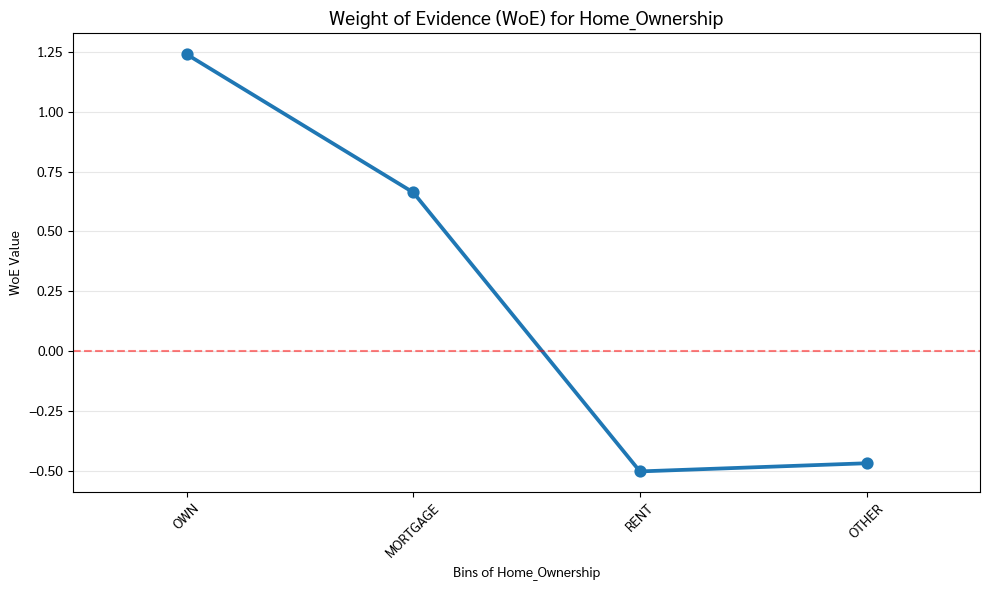

In [43]:
# 'person_home_ownership'
woe_df, iv_value = calculate_woe_iv(df, 'Home_Ownership', 'Loan_Status')
print(f"Information Value: {iv_value}")
print(woe_df)

plot_woe(woe_df, 'Home_Ownership')

In [44]:
ks_score, ks_table = calculate_ks(woe_df)
print(f"KS Statistic: {ks_score:.4f}")

KS Statistic: 0.2904


#### ตัวแปร 'income_bin'

In [45]:
# We define clear cut-off points: 0 -> 35k -> 60k -> 85k -> Infinity
bins = [0, 35000, 60000, 85000, float('inf')]
labels = ['1. Low (<35k)', '2. Medium (35k-60k)', '3. High (60k-85k)', '4. Very High (>85k)']

# Use pd.cut instead of qcut
df['income_bin'] = pd.cut(df['Income'], bins=bins, labels=labels)

Information Value: 0.4499815912648941
                 Value    All  Good   Bad  Dist_Good  Dist_Bad       WoE  \
0        1. Low (<35k)   6629  3761  2868   0.147687  0.403546 -1.005194   
1    3. High (60k-85k)   7251  6178  1073   0.242598  0.150978  0.474272   
2  2. Medium (35k-60k)  12095  9543  2552   0.374735  0.359083  0.042667   
3  4. Very High (>85k)   6598  5984   614   0.234980  0.086394  1.000586   

         IV  
0  0.257188  
1  0.043453  
2  0.000668  
3  0.148673  


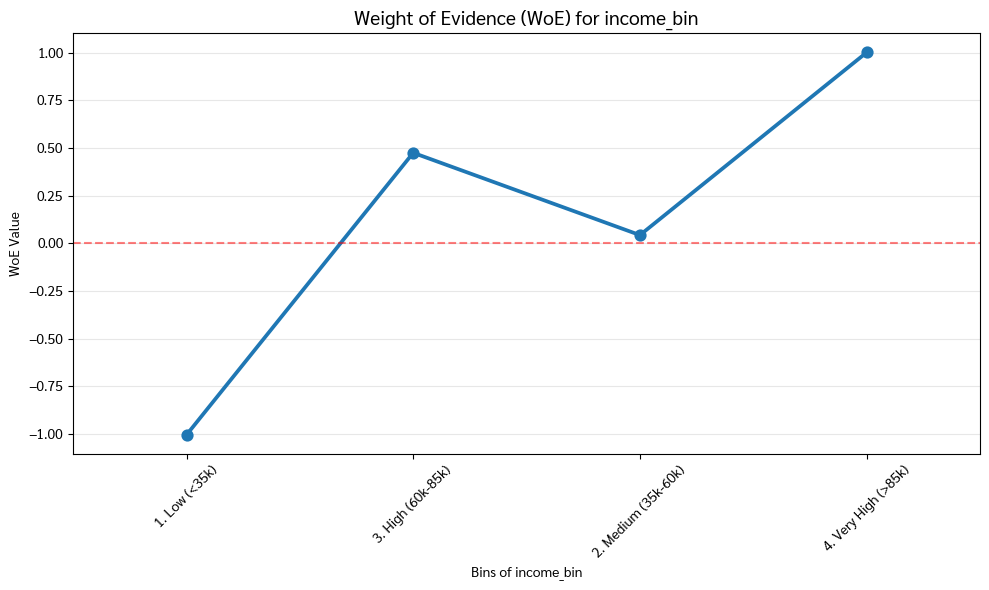

In [46]:
# 'income_bin'
woe_df, iv_value = calculate_woe_iv(df, 'income_bin', 'Loan_Status')
print(f"Information Value: {iv_value}")
print(woe_df)

plot_woe(woe_df, 'income_bin')

In [47]:
ks_score, ks_table = calculate_ks(woe_df)
print(f"KS Statistic: {ks_score:.4f}")

KS Statistic: 0.2559


#### ตัวแปร 'Loan_Int_Rate'

In [48]:
# 1. Create the Bins (Use qcut as you did originally)

df_woe = df.copy()
df_woe['Loan_Int_Rate_bin'] = pd.qcut(df_woe['Loan_Int_Rate'], q=5, precision=0)

In [49]:
# 2. Fill Missing Values
df_woe['Loan_Int_Rate_bin'] = df_woe['Loan_Int_Rate_bin'].cat.add_categories(['Missing'])
df_woe['Loan_Int_Rate_bin'] = df_woe['Loan_Int_Rate_bin'].fillna('Missing')

In [50]:
print("\nDistribution of Loan_Int_Rate_bin:")
print(df_woe['Loan_Int_Rate_bin'].value_counts())


Distribution of Loan_Int_Rate_bin:
Loan_Int_Rate_bin
(4.0, 8.0]      6015
(8.0, 10.0]     5987
(14.0, 23.0]    5867
(12.0, 14.0]    5812
(10.0, 12.0]    5778
Missing         3114
Name: count, dtype: int64


Information Value: 0.6182518223780366


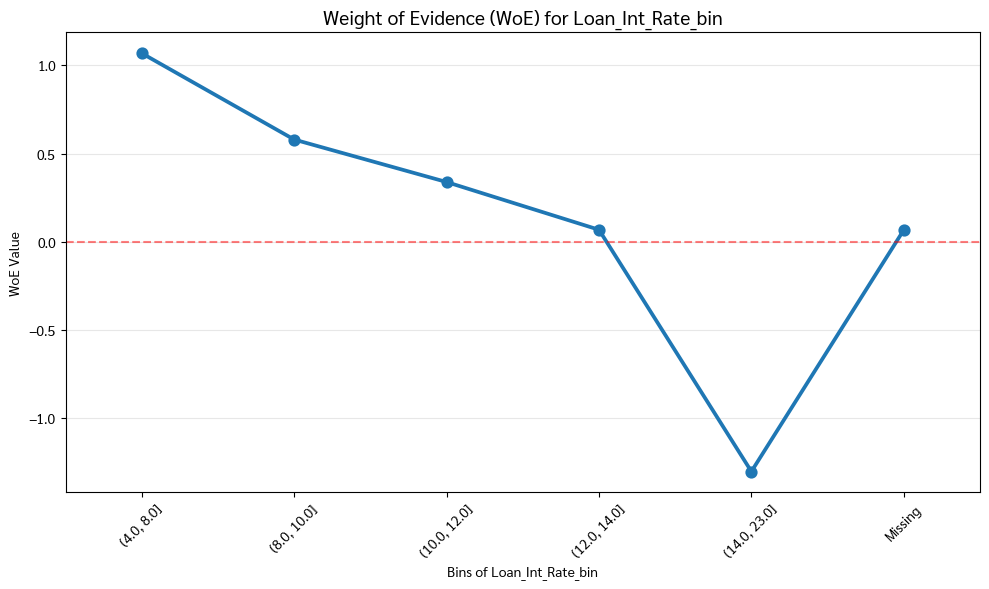

In [51]:
# 1. Calculate WOE first
woe_emp, iv_emp = calculate_woe_iv(df_woe, 'Loan_Int_Rate_bin', 'Loan_Status')

# --- THE ROBUST FIX ---
# Step A: Separate the 'Missing' row from the 'Interval' rows
missing_row = woe_emp[woe_emp['Value'] == 'Missing']
interval_rows = woe_emp[woe_emp['Value'] != 'Missing']

# Step B: Sort only the Interval rows (Python can sort these easily now)
interval_rows = interval_rows.sort_values(by='Value')

# Step C: Combine them back together (Putting 'Missing' at the end)
woe_emp = pd.concat([interval_rows, missing_row])
# ----------------------

# 2. Print and Plot
print(f"Information Value: {iv_emp}")
plot_woe(woe_emp, 'Loan_Int_Rate_bin')

In [52]:
ks_score, ks_table = calculate_ks(woe_emp)
print(f"KS Statistic: {ks_score:.4f}")

KS Statistic: 0.3040


#### IV > 0.5 ถือว่า "สูง/ผิดปกติ (อาจเกิดการโอเวอร์ฟิตติ้งหรือการรั่วไหลของข้อมูล)" ในการประเมินความเสี่ยงด้านเครดิต อัตราดอกเบี้ยมักจะถูกกำหนดหลังจากประเมินความเสี่ยงแล้ว 

#### ตัวแปร 'Age'

In [53]:
# การแบ่งช่วงอายุ (Age) ตามเกณฑ์ที่กำหนดเอง
bins = [0, 25, 35, 45, 60, 100]
labels = ['<25', '25-35', '35-45', '45-60', '>60']

df['age_bin'] = pd.cut(df['Age'], bins=bins, labels=labels)

Information Value: 0.004735837352210721
   Value    All   Good   Bad  Dist_Good  Dist_Bad       WoE            IV
0    <25  15350  11816  3534   0.463991  0.497256 -0.069240  2.303265e-03
1  25-35  13763  10917  2846   0.428689  0.400450  0.068143  1.924280e-03
2  35-45   2814   2231   583   0.087607  0.082032  0.065754  3.665920e-04
3  45-60    582    455   127   0.017867  0.017870 -0.000154  4.220216e-10
4    >60     64     47    17   0.001846  0.002392 -0.259330  1.417003e-04


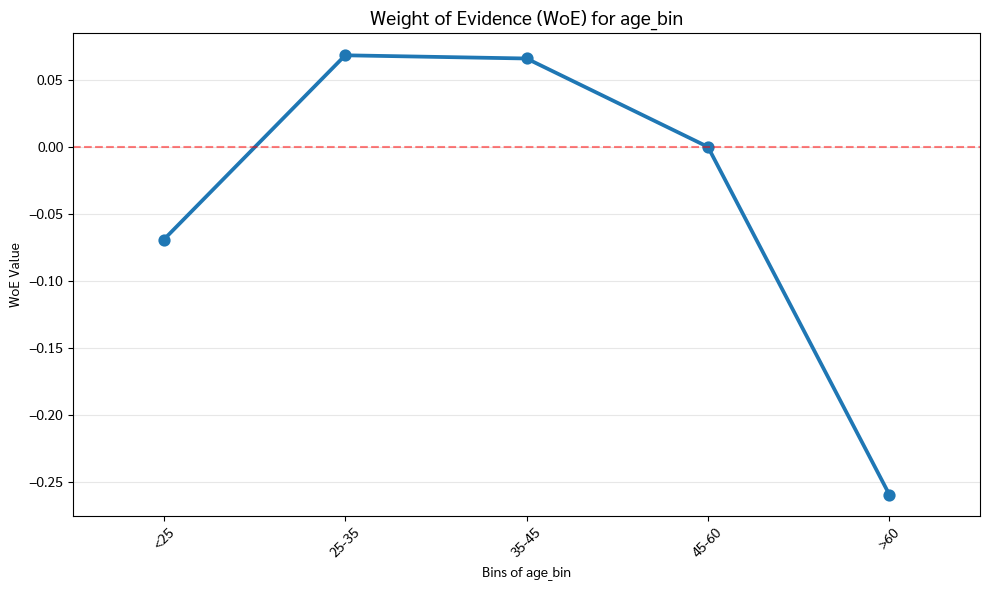

In [54]:
woe_df, iv_value = calculate_woe_iv(df, 'age_bin', 'Loan_Status')
print(f"Information Value: {iv_value}")
print(woe_df)

plot_woe(woe_df, 'age_bin')

In [55]:
ks_score, ks_table = calculate_ks(woe_df)
print(f"KS Statistic: {ks_score:.4f}")

KS Statistic: 0.0338


#### ตัวแปร 'Emp_Length'

<Axes: >

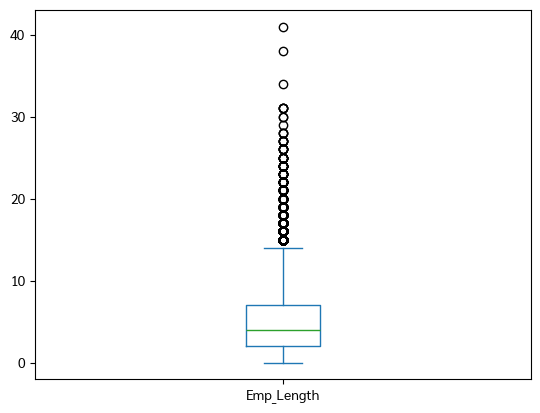

In [56]:
df['Emp_Length'].dropna().plot.box()

In [57]:
df['Emp_Length'].max()

41

In [58]:
# Make a copy to avoid SettingWithCopy warnings
df_woe = df.copy()

bins_emp = [0, 2, 4, 6, 8, 10, 40, float('inf')]
labels_emp = ['<2', '2-4', '4-6', '6-8', '8-10', '10-40', '>40']

# Create the bins
df_woe['Emp_Length_bin'] = pd.cut(df_woe['Emp_Length'], bins=bins_emp, labels=labels_emp, right=False)

In [59]:
# Add 'Missing' to the category list and then fill NaNs
df_woe['Emp_Length_bin'] = df_woe['Emp_Length_bin'].cat.add_categories(['Missing'])
df_woe['Emp_Length_bin'] = df_woe['Emp_Length_bin'].fillna('Missing')

In [60]:
# Check the distribution (Missing should now appear in the list)
print("Distribution of Emp_Length_bin:")
print(df_woe['Emp_Length_bin'].value_counts())

Distribution of Emp_Length_bin:
Emp_Length_bin
2-4        7304
<2         7019
4-6        5818
6-8        4861
10-40      3621
8-10       3054
Missing     895
>40           1
Name: count, dtype: int64


Information Value: 0.060787929396711224
     Value   All  Good   Bad  Dist_Good  Dist_Bad       WoE        IV
1       <2  7019  5066  1953   0.198932  0.274799 -0.323079  0.024511
3      2-4  7304  5621  1683   0.220726  0.236809 -0.070332  0.001131
0      4-6  5818  4660  1158   0.182989  0.162938  0.116057  0.002327
4      6-8  4861  3949   912   0.155070  0.128324  0.189314  0.005063
2     8-10  3054  2529   525   0.099309  0.073871  0.295917  0.007528
5    10-40  3621  3027   594   0.118864  0.083580  0.352184  0.012427
7      >40     1     1     0   0.000039  0.000000  0.000000  0.000000
6  Missing   895   613   282   0.024071  0.039679 -0.499806  0.007801


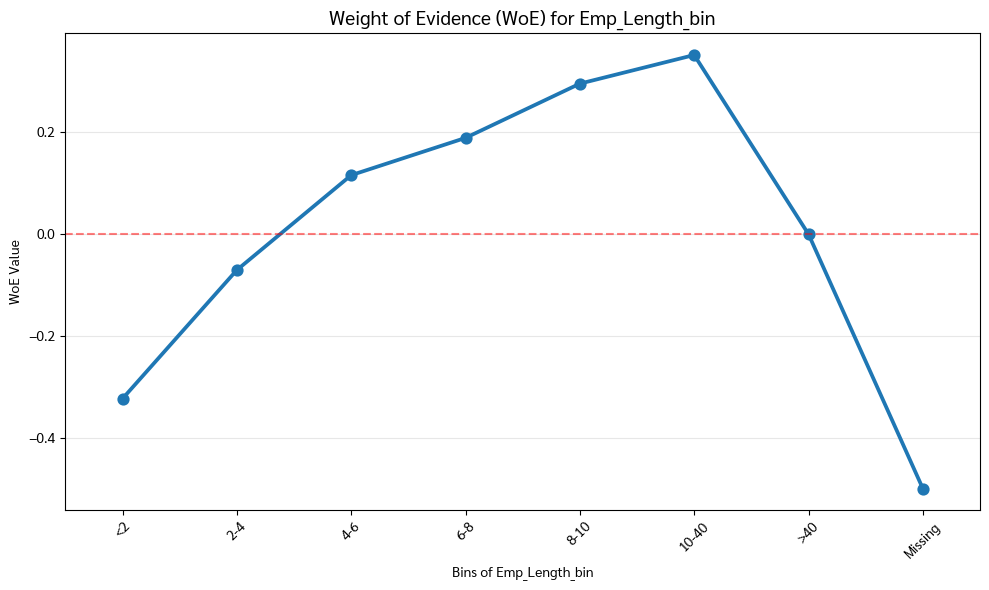

In [61]:
woe_df, iv_value = calculate_woe_iv(df_woe, 'Emp_Length_bin', 'Loan_Status')

# 1. Define the correct logical order (Must match Cell 60 exactly)
# We add 'Missing' at the end manually
custom_order = ['<2', '2-4', '4-6', '6-8', '8-10', '10-40', '>40', 'Missing']

# 2. Convert the 'Value' column to a Category type with this specific order
woe_df['Value'] = pd.Categorical(woe_df['Value'], categories=custom_order, ordered=True)

# 3. Sort by this new logical order
woe_df = woe_df.sort_values(by='Value')

# 4. Print and Plot (Fixed the label name here)
print(f"Information Value: {iv_value}")
print(woe_df)

# Fix the label below to 'Emp_Length_bin'
plot_woe(woe_df, 'Emp_Length_bin')

In [62]:
ks_score, ks_table = calculate_ks(woe_df)
print(f"KS Statistic: {ks_score:.4f}")

KS Statistic: 0.1076


#### ตัวแปร 'loan_amnt'

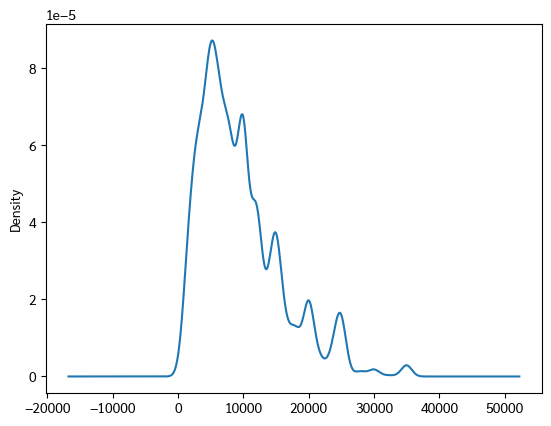

In [63]:
# single column (density)
df['Loan_Amnt'].plot(kind='kde')
plt.show()

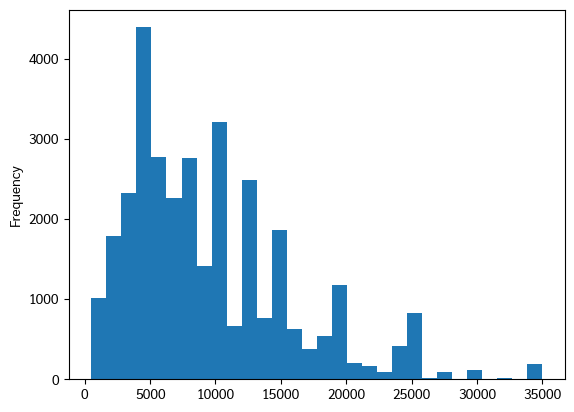

In [64]:
df['Loan_Amnt'].plot(kind='hist', bins=30)
plt.show()

In [65]:
# Make a copy to avoid SettingWithCopy warnings
df_woe = df.copy()

# Make a copy to avoid SettingWithCopy warnings
df_woe['Loan_Amnt_bin'] = pd.qcut(df_woe['Loan_Amnt'], q=5, precision=0)

In [66]:
print("\nDistribution of Loan_Amnt_bin:")
print(df_woe['Loan_Amnt_bin'].value_counts())


Distribution of Loan_Amnt_bin:
Loan_Amnt_bin
(6750.0, 10000.0]     8493
(499.0, 4400.0]       6543
(4400.0, 6750.0]      6489
(14500.0, 35000.0]    6489
(10000.0, 14500.0]    4559
Name: count, dtype: int64


Information Value: 0.07343228865451851
                Value   All  Good   Bad  Dist_Good  Dist_Bad       WoE  \
0     (499.0, 4400.0]  6543  5172  1371   0.203094  0.192908  0.051455   
1    (4400.0, 6750.0]  6489  5366  1123   0.210712  0.158013  0.287815   
3   (6750.0, 10000.0]  8493  6881  1612   0.270203  0.226819  0.175024   
4  (10000.0, 14500.0]  4559  3564   995   0.139951  0.140003 -0.000368   
2  (14500.0, 35000.0]  6489  4483  2006   0.176039  0.282257 -0.472114   

             IV  
0  5.241171e-04  
1  1.516759e-02  
3  7.593392e-03  
4  1.895253e-08  
2  5.014717e-02  


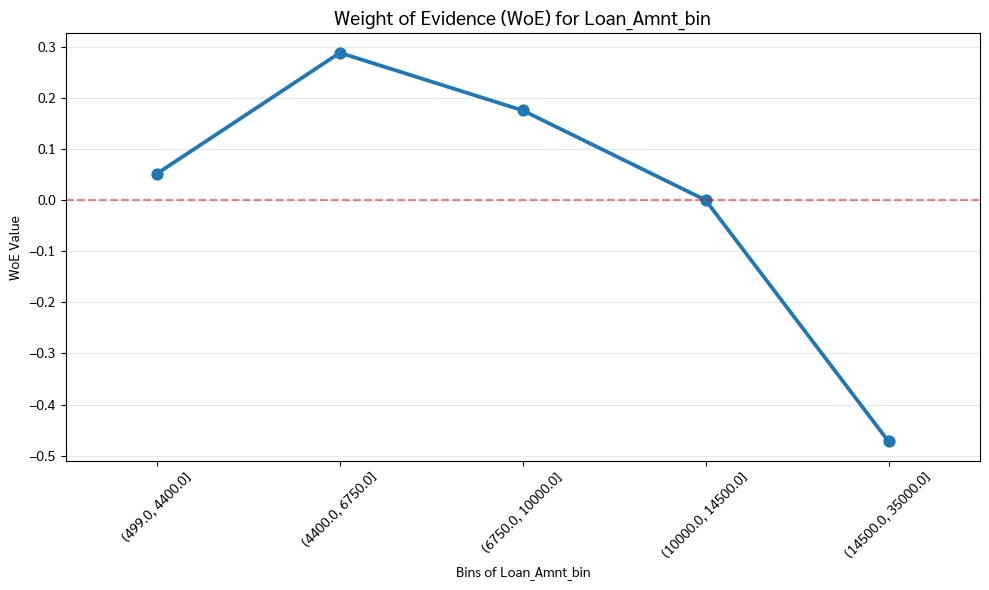

In [67]:
# Calculate WOE for Loan Amount
woe_df, iv_value = calculate_woe_iv(df_woe, 'Loan_Amnt_bin', 'Loan_Status')

# --- THE FIX: Sort the bins numerically ---
# This ensures small loans appear on the left and large loans on the right
woe_df = woe_df.sort_values(by='Value')
# ------------------------------------------

print(f"Information Value: {iv_value}")
print(woe_df)

plot_woe(woe_df, 'Loan_Amnt_bin')

In [68]:
ks_score, ks_table = calculate_ks(woe_df)
print(f"KS Statistic: {ks_score:.4f}")

KS Statistic: 0.1063


#### ตัวแปร 'Loan_Percent_Income_bin'

In [69]:
df_woe = df.copy()

df['Loan_Percent_Income_bin'] = pd.qcut(df['Loan_Percent_Income'], q=5, precision=2)
woe_lpi, iv_lpi = calculate_woe_iv(df, 'Loan_Percent_Income_bin', 'Loan_Status')

In [70]:
# Check the distribution (Missing should now appear in the list)
print("Distribution of Loan_Percent_Income_bin:")
print(df['Loan_Percent_Income_bin'].value_counts())

Distribution of Loan_Percent_Income_bin:
Loan_Percent_Income_bin
(-0.01, 0.08]    7569
(0.12, 0.18]     7343
(0.25, 0.83]     6277
(0.18, 0.25]     5799
(0.08, 0.12]     5585
Name: count, dtype: int64


Information Value: 0.7065981710724284
           Value   All  Good   Bad  Dist_Good  Dist_Bad       WoE        IV
4  (-0.01, 0.08]  7569  6705   864   0.263292  0.121570  0.772772  0.109519
0   (0.08, 0.12]  5585  4889   696   0.191981  0.097932  0.673129  0.063308
3   (0.12, 0.18]  7343  6229  1114   0.244601  0.156747  0.444995  0.039094
2   (0.18, 0.25]  5799  4689  1110   0.184128  0.156184  0.164595  0.004599
1   (0.25, 0.83]  6277  2954  3323   0.115998  0.467567 -1.393972  0.490078


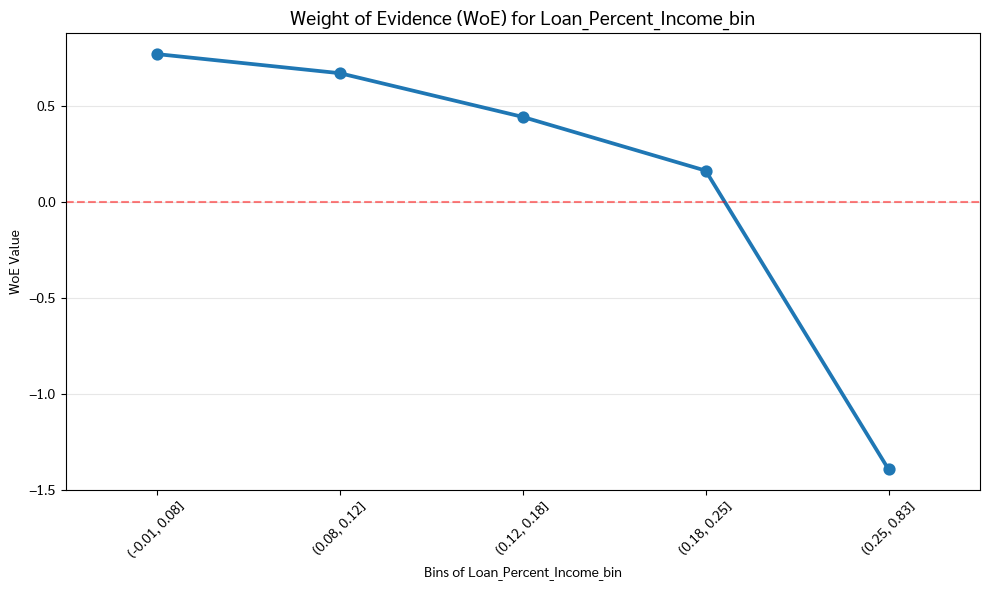

In [71]:
# Calculate WOE for Loan_Percent_Income_bin
woe_df, iv_value = calculate_woe_iv(df, 'Loan_Percent_Income_bin', 'Loan_Status')

# Sort the bins numerically
woe_df = woe_df.sort_values(by='Value')

print(f"Information Value: {iv_value}")
print(woe_df)

plot_woe(woe_df, 'Loan_Percent_Income_bin')

In [72]:
ks_score, ks_table = calculate_ks(woe_df)
print(f"KS Statistic: {ks_score:.4f}")

KS Statistic: 0.3516


### Loan_Intent (Categorical)

Information Value: 0.0956766961369648
               Value   All  Good   Bad  Dist_Good  Dist_Bad       WoE  \
5  DEBTCONSOLIDATION  5212  3722  1490   0.146156  0.209652 -0.360779   
1            MEDICAL  6070  4449  1621   0.174704  0.228085 -0.266628   
4    HOMEIMPROVEMENT  3605  2664   941   0.104610  0.132405 -0.235623   
3           PERSONAL  5519  4422  1097   0.173643  0.154355  0.117749   
0          EDUCATION  6451  5340  1111   0.209691  0.156325  0.293701   
2            VENTURE  5716  4869   847   0.191196  0.119178  0.472679   

         IV  
5  0.022908  
1  0.014233  
4  0.006549  
3  0.002271  
0  0.015674  
2  0.034041  


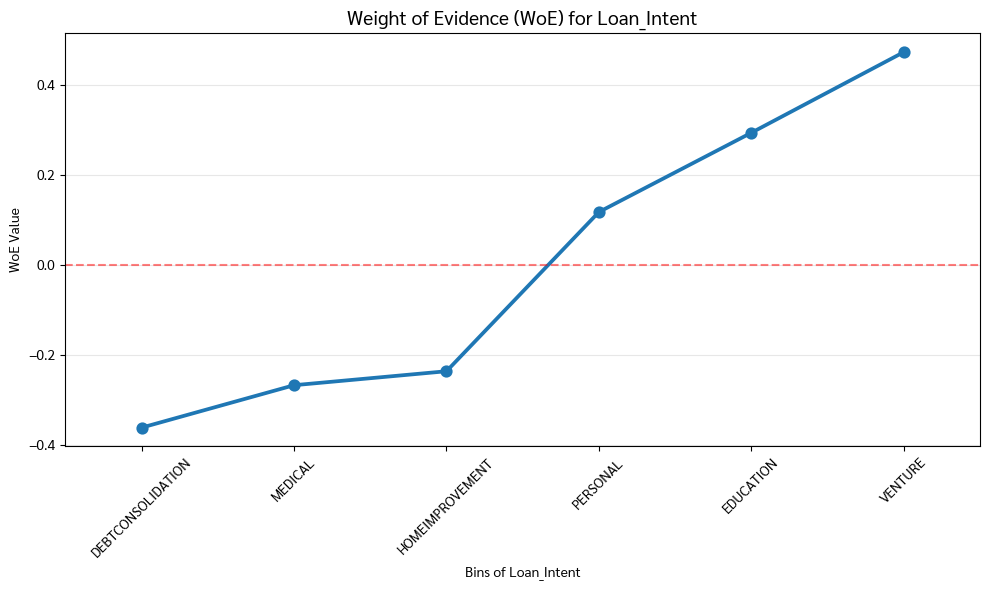

In [73]:
# 2. Loan_Intent (Categorical)
woe_intent, iv_intent = calculate_woe_iv(df, 'Loan_Intent', 'Loan_Status')

# --- FIX: Sort by 'WoE' (Risk) instead of Alphabetical ---
# This makes the graph trend nicely from Low Risk -> High Risk
woe_intent = woe_intent.sort_values(by='WoE')
# --------------------------------------------------------

print(f"Information Value: {iv_intent}")
print(woe_intent)

plot_woe(woe_intent, 'Loan_Intent')

In [74]:
ks_score, ks_table = calculate_ks(woe_intent)
print(f"KS Statistic: {ks_score:.4f}")

KS Statistic: 0.1447


### Cb_Default_On_File (Categorical)

Information Value: 0.16374731059533648
  Value    All   Good   Bad  Dist_Good  Dist_Bad       WoE        IV
1     Y   5744   3573  2171   0.140305  0.305473 -0.778046  0.128509
0     N  26829  21893  4936   0.859695  0.694527  0.213348  0.035238


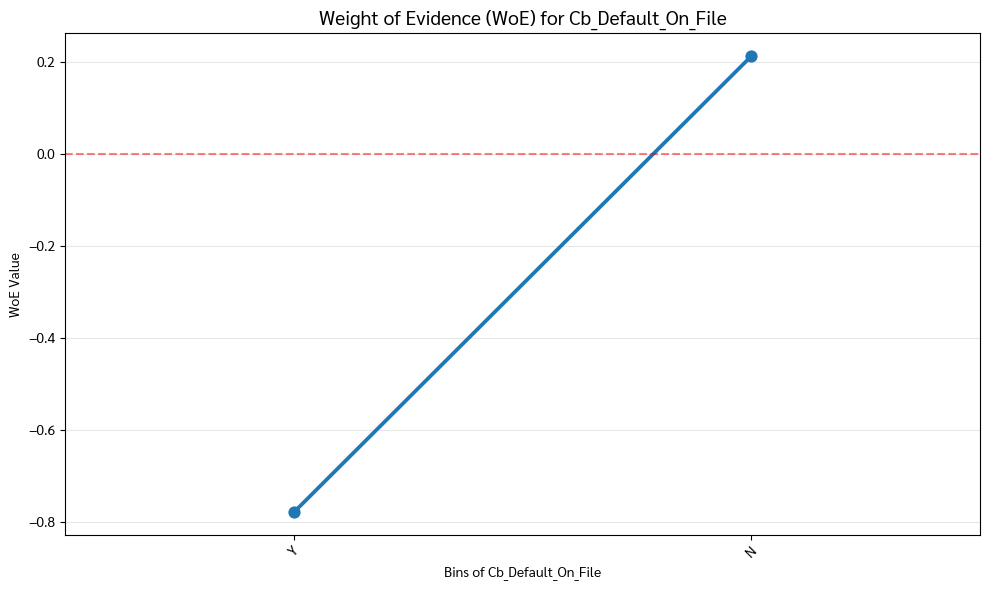

In [75]:
# 3. Cb_Default_On_File (Categorical)
woe_cb, iv_cb = calculate_woe_iv(df, 'Cb_Default_On_File', 'Loan_Status')

# --- FIX: Sort by 'WoE' ---
woe_cb = woe_cb.sort_values(by='WoE')
# --------------------------

print(f"Information Value: {iv_cb}")
print(woe_cb)

plot_woe(woe_cb, 'Cb_Default_On_File')

In [76]:
ks_score, ks_table = calculate_ks(woe_cb)
print(f"KS Statistic: {ks_score:.4f}")

KS Statistic: 0.1652


### การแปลความหมายค่า KS
ค่า KS จะมีค่าอยู่ระหว่าง 0 ถึง 1 (หรือ 0% ถึง 100%):

> < 20%: ความสามารถในการแยกแยะต่ำมาก (โมเดลใช้ไม่ได้)

> 20% - 40%: ความสามารถในการแยกแยะปานกลาง (ยอมรับได้สำหรับงานทั่วไป)

> 40% - 50%: ดีมาก (Good) เป็นช่วงที่เหมาะสมสำหรับ Credit Scoring

> 50% - 70%: ยอดเยี่ยม (Excellent)

> 70%>: สูงผิดปกติ (อาจเกิด Overfitting หรือตัวแปรนั้นมีเฉลยอยู่ในตัวแล้ว เช่น เอาคอลัมน์ "ยอดค้างชำระปัจจุบัน" ไปทำนาย "การเบี้ยวหนี้")

### เกณฑ์การแปลความหมาย IV:

> <0.02: ไม่มีอำนาจในการพยากรณ์

>0.02 - 0.1: อำนาจการพยากรณ์ต่ำ

>0.1 - 0.3: อำนาจการพยากรณ์ปานกลาง

>0.3 - 0.5: อำนาจการพยากรณ์สูง

> 0.5>: สูงผิดปกติ (อาจเกิด Overfitting หรือ Data Leakage)

## Logistic Regression Model (WOE-based Credit Scoring Model)

In [77]:
# --- 1. Consolidate Binning into Main DataFrame (df) ---

# Income Binning
df['income_bin'] = pd.qcut(df['Income'], q=5, precision=0)

# Emp_Length Binning (Your logic from the screenshot, applied to df)
bins_emp = [0, 2, 4, 6, 8, 10, 40, float('inf')]
labels_emp = ['<2', '2-4', '4-6', '6-8', '8-10', '10-40', '>40']
df['Emp_Length_bin'] = pd.cut(df['Emp_Length'], bins=bins_emp, labels=labels_emp, right=False)
df['Emp_Length_bin'] = df['Emp_Length_bin'].cat.add_categories(['Missing']).fillna('Missing')

# Loan Amount Binning
df['Loan_Amnt_bin'] = pd.qcut(df['Loan_Amnt'], q=5, precision=0)

# Loan Percent Income Binning (Adding this as it's a strong predictor)
#df['Loan_Percent_Income_bin'] = pd.qcut(df['Loan_Percent_Income'], q=5, precision=2)

print("Binning complete. Columns in df:", df.columns)

Binning complete. Columns in df: Index(['Age', 'Income', 'Home_Ownership', 'Emp_Length', 'Loan_Intent',
       'Loan_Grade', 'Loan_Amnt', 'Loan_Int_Rate', 'Loan_Status',
       'Loan_Percent_Income', 'Cb_Default_On_File', 'Cb_Cred_Hist_Length',
       'income_bin', 'age_bin', 'Loan_Percent_Income_bin', 'Emp_Length_bin',
       'Loan_Amnt_bin'],
      dtype='object')


In [78]:
# --- 2. Calculate WOE for each feature and save to unique variables ---

# Home Ownership
woe_home, iv_home = calculate_woe_iv(df, 'Home_Ownership', 'Loan_Status')

# Income
woe_income, iv_income = calculate_woe_iv(df, 'income_bin', 'Loan_Status')

# Emp Length
woe_emp, iv_emp = calculate_woe_iv(df, 'Emp_Length_bin', 'Loan_Status')

# Loan Amount
woe_amnt, iv_amnt = calculate_woe_iv(df, 'Loan_Amnt_bin', 'Loan_Status')

# Loan Percent Income
#woe_lpi, iv_lpi = calculate_woe_iv(df, 'Loan_Percent_Income_bin', 'Loan_Status')

print("WOE Tables ready.")

WOE Tables ready.


In [79]:
# --- 3. Transform Data to WOE Values ---

def replace_with_woe(df, woe_df_list, feature_map):
    df_woe_final = df.copy()
    for col_name, woe_df in woe_df_list.items():
        woe_map = dict(zip(woe_df['Value'], woe_df['WoE']))
        binned_col = feature_map[col_name]
        df_woe_final[col_name + '_woe'] = df_woe_final[binned_col].map(woe_map)
    return df_woe_final

# Dictionary of your calculated WOE dataframes
woe_dataframes = {
    'Home_Ownership': woe_home,
    'Income': woe_income,
    'Emp_Length': woe_emp,
    'Loan_Amnt': woe_amnt,
}

# Mapping: {Feature Name in woe_dataframes : Column Name in df}
feature_map = {
    'Home_Ownership': 'Home_Ownership',
    'Income': 'income_bin',
    'Emp_Length': 'Emp_Length_bin',
    'Loan_Amnt': 'Loan_Amnt_bin',
}

# Transform
final_train_df = replace_with_woe(df, woe_dataframes, feature_map)


# Show the result
pd.reset_option('display.float_format')
print(final_train_df.filter(like='_woe').head())


   Home_Ownership_woe Income_woe Emp_Length_woe Loan_Amnt_woe
1            1.240513  -1.005194       0.116057      0.051455
2            0.662946  -1.005194      -0.323079      0.287815
3           -0.502822   0.493634       0.116057     -0.472114
4           -0.502822   0.227718       0.295917     -0.472114
5            1.240513  -1.005194      -0.070332      0.051455


In [80]:
# 1. Define X (Features) and y (Target)
# We only use the WOE columns we just created.
# Note: We EXCLUDE 'Loan_Int_Rate' (Leakage) and 'Age' (Weak)
feature_cols = [
    'Home_Ownership_woe',
    'Income_woe',
    'Emp_Length_woe',
    'Loan_Amnt_woe',
]

X = final_train_df[feature_cols]
y = final_train_df['Loan_Status']

# 2. Train-Test Split (80% Train, 20% Test)
# random_state=42 ensures we get the same split every time we run it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train Logistic Regression Model (using Statsmodels)
# Statsmodels requires us to manually add a constant (Intercept)
X_train_const = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

# 4. Print Model Summary
# Look for P>|z|. If value is < 0.05, the variable is significant.
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.437764
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:                26058
Model:                          Logit   Df Residuals:                    26053
Method:                           MLE   Df Model:                            4
Date:                Sat, 27 Dec 2025   Pseudo R-squ.:                  0.1648
Time:                        11:22:31   Log-Likelihood:                -11407.
converged:                       True   LL-Null:                       -13658.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.3031      0.017    -75.582      0.000      -1.337      -1.269
Home_

1) โมเดล converge สำเร็จ และมีนัยสำคัญโดยรวม (LLR p-value = 0.000) ⇒ โมเดลดีกว่าการเดาสุ่มอย่างมีนัยสำคัญ

Pseudo R² = 0.1648 ⇒ ระดับปานกลาง (ถือว่าโอเคสำหรับ credit scoring)

ใช้ข้อมูล 26,058 รายการ และตัวแปร 4 ตัว (+ intercept)

2) นัยสำคัญของตัวแปร

ตัวแปรทุกตัวมี p-value < 0.05 ⇒ มีนัยสำคัญทางสถิติทั้งหมด ควรเก็บไว้

3) การตีความค่าสัมประสิทธิ์ (Coef)

เนื่องจากเป็น WOE และ target คือ Loan_Status (ผิดนัด)
ค่า coef ติดลบ ⇒ WOE สูงขึ้น → ความเสี่ยงผิดนัด ลดลง

Loan_Amnt_woe (-2.557) → แรงที่สุด
ขนาดเงินกู้เป็นตัวขับเคลื่อนความเสี่ยงหลัก

Income_woe (-1.251) → อันดับสอง
รายได้สูง (WOE ดี) ลดความเสี่ยงชัดเจน

Home_Ownership_woe (-0.854) → อันดับสาม
รูปแบบการอยู่อาศัยมีผลต่อความเสี่ยง

Emp_Length_woe (-0.220) → อ่อนที่สุด
แต่ยังมีนัยสำคัญ (p = 0.002)

AUC Score: 0.7614
Gini Coefficient: 0.5229


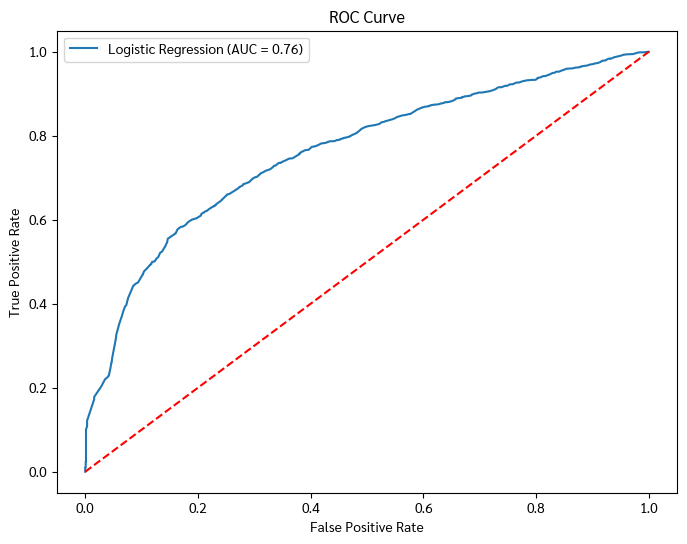

In [81]:
# Predict on the Test Set
X_test_const = sm.add_constant(X_test)
y_pred_prob = result.predict(X_test_const)

# Calculate AUC (Area Under Curve)
auc = roc_auc_score(y_test, y_pred_prob)
gini = 2 * auc - 1

print(f"AUC Score: {auc:.4f}")
print(f"Gini Coefficient: {gini:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--') # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

โมเดลมีความสามารถแยกกลุ่มลูกค้าที่เสี่ยงกับไม่เสี่ยงได้ค่อนข้างดีแต่ยังไม่ถึงขั้นยอดเยี่ยม โดย

AUC = 0.7614 หมายถึงโมเดลมีโอกาส ~76% ที่จะจัดอันดับลูกค้าที่ผิดนัดสูงกว่าลูกค้าที่ไม่ผิดนัด (ดีกว่าการเดาสุ่มชัดเจน)

Gini = 0.5229 ถือว่าอยู่ในระดับ ใช้งานได้จริง (acceptable–good) สำหรับโมเดล credit scoring

จากกราฟ ROC เส้นโค้งอยู่เหนือเส้นสุ่มค่อนข้างมาก แปลว่าโมเดลเรียนรู้สัญญาณความเสี่ยงได้จริง แต่ยังมีช่องให้ปรับปรุง (เช่น feature เพิ่ม / binning / interaction)

In [82]:
# Predict PD on Test Set
X_test_const = sm.add_constant(X_test)
y_pred_prob = result.predict(X_test_const)


In [83]:
df_ks_model = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_prob
})

# Sort by predicted probability (Low risk -> High risk)
df_ks_model = df_ks_model.sort_values(by='y_pred').reset_index(drop=True)


In [84]:
# Define Good / Bad
df_ks_model['Good'] = (df_ks_model['y_true'] == 0).astype(int)
df_ks_model['Bad'] = (df_ks_model['y_true'] == 1).astype(int)

# Distribution
df_ks_model['Dist_Good'] = df_ks_model['Good'] / df_ks_model['Good'].sum()
df_ks_model['Dist_Bad'] = df_ks_model['Bad'] / df_ks_model['Bad'].sum()

# Cumulative Distribution
df_ks_model['Cum_Good'] = df_ks_model['Dist_Good'].cumsum()
df_ks_model['Cum_Bad'] = df_ks_model['Dist_Bad'].cumsum()

# KS Difference
df_ks_model['KS_Diff'] = np.abs(df_ks_model['Cum_Good'] - df_ks_model['Cum_Bad'])


In [85]:
ks_model = df_ks_model['KS_Diff'].max()
print(f"KS Statistic (Model): {ks_model:.4f}")


KS Statistic (Model): 0.4156


In [86]:
# หา KS สูงสุด (ตำแหน่ง)
ks_max = df_ks_model['KS_Diff'].max()
ks_idx = df_ks_model['KS_Diff'].idxmax()

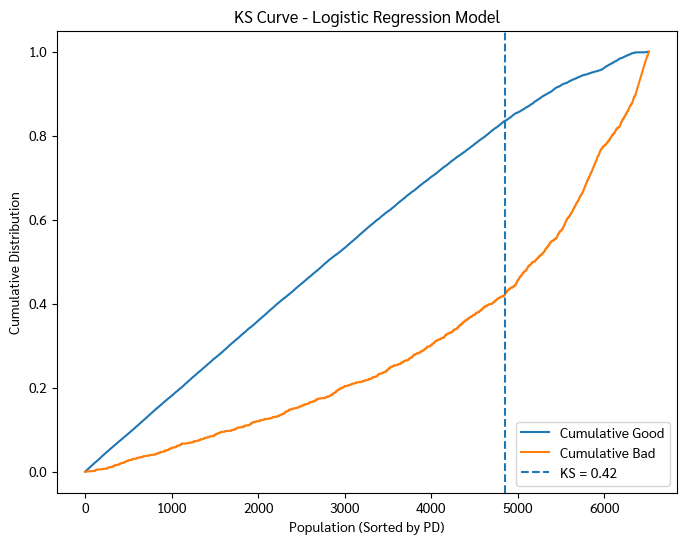

In [95]:
plt.figure(figsize=(8, 6))

# Cumulative curves
plt.plot(df_ks_model['Cum_Good'], label='Cumulative Good')
plt.plot(df_ks_model['Cum_Bad'], label='Cumulative Bad')

# Vertical line at KS point
plt.axvline(x=ks_idx, linestyle='--', label=f'KS = {ks_max:.2f}')

plt.xlabel('Population (Sorted by PD)')
plt.ylabel('Cumulative Distribution')
plt.title('KS Curve - Logistic Regression Model')
plt.legend(loc='lower right')
plt.show()

## Interpreting the results

1. ภาพรวมและวัตถุประสงค์โปรเจกต์นี้จัดทำขึ้นเพื่อสร้าง แบบจำลองคะแนนเครดิต (Credit Scoring Model) โดยใช้เทคนิค Logistic Regression เพื่อทำนายโอกาสในการผิดนัดชำระหนี้ (Default) จากข้อมูลลูกค้าจำนวน 32,581 ราย 

2. ปัจจัยเสี่ยงที่สำคัญ (Key Risk Drivers)จากการวิเคราะห์ความสัมพันธ์ (Correlation) และค่า Information Value (IV) พบว่าปัจจัยที่บ่งชี้ความเสี่ยงได้ดีที่สุดคือ:

- สัดส่วนหนี้ต่อรายได้ (Loan_Percent_Income): มีความสัมพันธ์กับการผิดนัดชำระหนี้สูงที่สุด ($r=0.38$) กล่าวคือ ยิ่งมีภาระหนี้สูงเมื่อเทียบกับรายได้ ยิ่งมีความเสี่ยงสูง
- อัตราดอกเบี้ย (Loan_Int_Rate): ดอกเบี้ยที่สูงมักสัมพันธ์กับกลุ่มที่มีความเสี่ยงสูง ($r=0.34$)
- สถานะที่อยู่อาศัย (Home_Ownership): ผู้ที่ "เช่า" (RENT) มีความเสี่ยงสูงกว่าผู้ที่เป็น "เจ้าของ" (OWN) หรือผ่อนบ้าน (MORTGAGE) อย่างชัดเจน
  
3. ประสิทธิภาพของโมเดล (Model Performance)
โมเดล Logistic Regression ที่สร้างขึ้น (โดยตัดตัวแปรดอกเบี้ยออกเพื่อป้องกัน Data Leakage) ให้ผลลัพธ์อยู่ในเกณฑ์ "ดี" (Good/Acceptable) สำหรับงาน Credit Scoring:

AUC Score = 0.7614:
โมเดลมีความสามารถในการแยกแยะคนดีกับคนที่จะเบี้ยวหนี้ได้ถูกต้องประมาณ 76% (ดีกว่าการเดาสุ่มชัดเจน) 

KS Statistic = 0.42 (หรือ 41.56%): ค่านี้ยืนยันว่าโมเดลสามารถแยกกลุ่มลูกค้าที่ดีและแย่ออกจากกันได้ดีที่สุดที่จุดตัดหนึ่ง (เกณฑ์ทั่วไปคือ 40-50% ถือว่าดีมาก) 

Gini Coefficient = 0.5229: อยู่ในระดับที่ยอมรับได้และใช้งานได้จริง 

4. ปัจจัยที่มีผลต่อคะแนนเครดิตมากที่สุด (ในโมเดลสุดท้าย)
เมื่อดูจากค่าสัมประสิทธิ์ (Coefficients) ในโมเดลสุดท้าย พบว่าปัจจัยที่ส่งผลต่อคะแนน (Score) เรียงจากมากไปน้อยคือ:
- วงเงินกู้ (Loan_Amount): มีผลมากที่สุด ยิ่งกู้เยอะ คะแนนยิ่งลดลง (ความเสี่ยงเพิ่ม)
- รายได้ (Income): มีผลรองลงมา รายได้สูงช่วยลดความเสี่ยงได้มาก
- ที่อยู่อาศัย (Home_Ownership): การเป็นเจ้าของบ้านช่วยเพิ่มคะแนนความน่าเชื่อถือ
- อายุงาน (Emp_Length): มีผลน้อยที่สุดในกลุ่ม แต่ก็ยังมีนัยสำคัญทางสถิติ

In [97]:
model_package = {
    'model': result,                # ตัวโมเดลที่ Train เสร็จแล้ว (จาก cell 80) [cite: 1640]
    'woe_maps': woe_dataframes,     # ตารางที่เก็บค่า WOE ของแต่ละตัวแปร (จาก cell 79) [cite: 1601]
    'feature_map': feature_map      # ตัวช่วยจับคู่ชื่อคอลัมน์ (จาก cell 79) [cite: 1608]
}


filename = 'model/credit_scorecard_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model_package, file)

print(f"บันทึกโมเดลเรียบร้อยแล้วที่: {filename}")

บันทึกโมเดลเรียบร้อยแล้วที่: model/credit_scorecard_model.pkl


## ScoreCard

### The Scoring Logic (WIP)

$$Score = Offset + Factor \times \ln(Odds)$$

In [82]:
# --- 1. Settings ---
TARGET_SCORE = 600
TARGET_ODDS = 50
PDO = 20

# Calculate Factor and Offset
factor = PDO / np.log(2)
offset = TARGET_SCORE - (factor * np.log(TARGET_ODDS))

print(f"Factor: {factor:.2f}")
print(f"Offset: {offset:.2f}")

# --- 2. Extract Coefficients ---
# Get the intercept (alpha) and feature coefficients (betas) from your model
intercept = result.params['const']
coeffs = result.params.drop('const')

# --- 3. Calculate Base Score ---
# Since your model predicts log(Bad/Good), and we want Score ~ log(Good/Bad),
# we negate the equation.
# Base Score = Offset + Factor * (-Intercept)
base_score = offset + (factor * -intercept)

print(f"Base Score (Intercept Points): {base_score:.0f}")

# --- 4. Generate Scorecard Table ---
scorecard = []

# List of your features and their corresponding original WOE dataframes
# IMPORTANT: Ensure 'woe_dataframes' dictionary (from previous steps) is available
features_list = {
    'Home_Ownership_woe': ('Home_Ownership', woe_home),
    'Income_woe': ('Income', woe_income),
    'Emp_Length_woe': ('Emp_Length', woe_emp),
    'Loan_Amnt_woe': ('Loan_Amnt', woe_amnt),
}

for col_model, (col_original, df_woe) in features_list.items():
    # Get the coefficient for this feature
    beta = coeffs[col_model]
    
    # Iterate through the bins in the WOE dataframe
    for index, row in df_woe.iterrows():
        woe_val = row['WoE']
        bin_label = row['Value']
        
        # Calculate Score Point for this bin
        # Point = (-Factor) * (Coefficient) * (WOE)
        points = (-factor) * beta * woe_val
        
        scorecard.append({
            'Feature': col_original,
            'Bin': bin_label,
            'WoE': woe_val,
            'Points': round(points) # Round to nearest integer
        })

# Create DataFrame
df_scorecard = pd.DataFrame(scorecard)

# --- 5. Display Final Scorecard ---
print("\n--- FINAL CREDIT SCORECARD ---")
print(f"Base Score: {round(base_score)}")
display(df_scorecard)

Factor: 28.85
Offset: 487.12
Base Score (Intercept Points): 525

--- FINAL CREDIT SCORECARD ---
Base Score: 525


,Feature,Bin,WoE,Points
0,Home_Ownership,OWN,1.240513,31
1,Home_Ownership,MORTGAGE,0.662946,16
2,Home_Ownership,RENT,-0.502822,-12
3,Home_Ownership,OTHER,-0.468706,-12
4,Income,"(3999.0, 35000.0]",-1.005194,-36
5,Income,"(63000.0, 86000.0]",0.493634,18
6,Income,"(49000.0, 63000.0]",0.227718,8
7,Income,"(86000.0, 2039784.0]",1.020571,37
8,Income,"(35000.0, 49000.0]",-0.093159,-3
9,Emp_Length,4-6,0.116057,1
